In [1]:
import sys
import os
import importlib
from   pathlib      import Path
import traceback

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats    import kruskal, wilcoxon, mannwhitneyu, ranksums
# from scipy.signal   import filter_design
from scipy.optimize import curve_fit
from lmfit import Model, Parameters

from eidynamics     import utils, plot_tools
from eidynamics     import pattern_index
import all_cells
rollvar_baseline = utils.mean_at_least_rolling_variance

sns.set_context('paper')
%matplotlib widget
%tb

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']
rocket_r    = mpl.colormaps['rocket_r']

color_E = flare
color_I = crest
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_squares_r = {1:rocket_r(0.2), 5:rocket_r(.4), 7:rocket_r(.6), 15:rocket_r(.8), 20:rocket_r(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
color_cells = mpl.colormaps['tab10']
Fs = 2e4

freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


No traceback available to show.


In [2]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure3v4\\")
data_path_FS                 = Path(r"parsed_data\\FreqSweep\\")
data_path_LTM                 = Path(r"parsed_data\\LTMRand\\")
data_path_grid               = Path(r"parsed_data\\Grid\\")
data_path_analysed           = Path(r"parsed_data\\second_order\\")
raw_data_path_cellwise       = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

### Load the data and make the plots

In [3]:
# Update September 2024
# September 2024
# short data path that contains the kernel fit data for FreqSweep protocol, also contains the field p2p data. latest and checked. Use this for all freqsweep measurements.
# Contains screening parameters also.
# 18Sep24
CC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_CC_kernelfit_response_measurements.h5"
cc_FS_shortdf = pd.read_hdf(CC_FS_shortdf_withkernelfit_datapath, key='data')
print(cc_FS_shortdf.shape)

CC_LTM_shortdf_withkernelfit_datapath = data_path_LTM / "all_cells_LTM_CC_kernelfit_response_measurements_noNANs.h5"
cc_LTM_shortdf = pd.read_hdf(CC_LTM_shortdf_withkernelfit_datapath, key='data')
print(cc_LTM_shortdf.shape)

cc_FS_LTM_shortdf = pd.concat([cc_FS_shortdf, cc_LTM_shortdf], axis=0, ignore_index=True)
# reset index
cc_FS_LTM_shortdf.reset_index(drop=True, inplace=True)

(4971, 163)
(540, 163)


In [4]:
# Data screening
# CC data screening based on dataflag_fields: protocol freqsweep
cc_FS_LTM_shortdf_slice = cc_FS_LTM_shortdf[
                                            (cc_FS_LTM_shortdf['location'] == 'CA1') &
                                            (cc_FS_LTM_shortdf['numSq'].isin([1,5,7,15])) &
                                            (cc_FS_LTM_shortdf['stimFreq'].isin([20,30,40,50])) &
                                            (cc_FS_LTM_shortdf['condition'] == 'Control') &
                                            (cc_FS_LTM_shortdf['ch0_response']==1) &
                                            (cc_FS_LTM_shortdf['IR'] >50) & (cc_FS_shortdf['IR'] < 300) &
                                            (cc_FS_LTM_shortdf['tau'] < 40) & 
                                            (cc_FS_LTM_shortdf['spike_in_baseline_period'] == 0) &
                                            (cc_FS_LTM_shortdf['ac_noise_power_in_ch0'] < 40) 
                                            ]
print(cc_FS_LTM_shortdf.shape, '--screened-->', cc_FS_LTM_shortdf_slice.shape)
screened_cc_trialIDs = cc_FS_LTM_shortdf_slice['trialID'].unique()

# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure3_screened_trialIDs_CC_FS_LTM.txt", screened_cc_trialIDs, fmt='%s')

cc_FS_LTM_shortdf_slice['patternList'] = cc_FS_LTM_shortdf_slice['patternList'].astype('int32')
patternIDs = np.sort( cc_FS_LTM_shortdf_slice[cc_FS_LTM_shortdf_slice['numSq'] != 1]['patternList'].unique() )

# take list stored in "peaks_field_norm" column and make it into new columns
cc_FS_LTM_shortdf_slice = utils.expand_list_column(cc_FS_LTM_shortdf_slice, 'peaks_field_norm', 'pfn_')

(5511, 163) --screened--> (2896, 163)
(2896, 163)
new columns:  ['pfn_0', 'pfn_1', 'pfn_2', 'pfn_3', 'pfn_4', 'pfn_5', 'pfn_6', 'pfn_7', 'pfn_8']
(2896, 9) (2896, 172)


C:\Users\adity\AppData\Local\Temp\ipykernel_20792\749248088.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_FS_LTM_shortdf_slice['patternList'] = cc_FS_LTM_shortdf_slice['patternList'].astype('int32')


In [5]:
VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data')
print(vc_FS_shortdf.shape)

# Load the long dataset
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5" 
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"

(4113, 163)


In [6]:
# take list stored in "peaks_field_norm" column and make it into new columns
vc_FS_shortdf = utils.expand_list_column(vc_FS_shortdf, 'peaks_field_norm', 'pfn_')

(4113, 163)
new columns:  ['pfn_0', 'pfn_1', 'pfn_2', 'pfn_3', 'pfn_4', 'pfn_5', 'pfn_6', 'pfn_7', 'pfn_8']
(4113, 9) (4113, 172)


In [7]:
# VC data screening
# VC data screening based on dataflag_fields
vc_FS_shortdf_slice = vc_FS_shortdf[
            (vc_FS_shortdf['location'] == 'CA1') &
            (vc_FS_shortdf['numSq'].isin([1,5,15])) &
            (vc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (vc_FS_shortdf['condition'] == 'Control') &
            (vc_FS_shortdf['ch0_response']==1) &
            # (vc_FS_shortdf['intensity'] == 100) &
            # (vc_FS_shortdf['pulseWidth'] == 2) &
            (vc_FS_shortdf['probePulseStart']==0.2) &
            (vc_FS_shortdf['IR'] >50) & (vc_FS_shortdf['IR'] < 300) &
            (vc_FS_shortdf['tau'] < 40) & 
            (vc_FS_shortdf['ac_noise_power_in_ch0'] < 40)&
            (vc_FS_shortdf['valley_0'].notnull())
        ]
print(vc_FS_shortdf.shape, '--screened-->', vc_FS_shortdf_slice.shape)
screened_vc_trialIDs = vc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { vc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {vc_FS_shortdf_slice['trialID'].nunique()}")

# save the screened trialIDs
# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure3_screened_trialIDs_VC_FS.txt", screened_vc_trialIDs, fmt='%s')

(4113, 172) --screened--> (1502, 172)
Unique cells in screened data: 12
Unique sweeps in screened data: 1502


In [8]:
def calculate_expected_response(celldf, pulse_index, freq, patternID,):
    """
    Calculate the expected response of a pattern based on the response to individual spots in the pattern
    """
    from eidynamics import pattern_index
    # constants
    Fs      = 2e4
    cellID  = celldf['cellID'].iloc[0]
    
    # checks
    field_data=True if celldf['numChannels'].iloc[0] == 4 else False

    # check if the given cell has 1sq data
    if not 1 in celldf['numSq'].unique():
        # print('No 1Sq data for this cell', celldf['numSq'].unique())
        # generate dataerror to be caught by the calling function
        raise ValueError(f'Cell: {cellID} - No 1Sq data for this cell. {pulse_index}, {freq}, {patternID}')
    # data
    pattern_response_df             = celldf[(celldf['patternList'] == patternID) & (celldf['stimFreq'] == freq)  ]
    if pattern_response_df.shape[0] == 0:
        raise ValueError(f'Cell: {cellID} - No data for this pattern {patternID} and freq {freq} Hz')
    
    # get the pattern
    constituent_spots_of_pattern    = pattern_index.get_patternIDlist_for_nSq_pattern(patternID) #1sq spots that make the pattern in the patternID
    numSq                           = len(constituent_spots_of_pattern)

    obs_col = 'PSC_' + str(pulse_index)
    obs_col_field = 'pfn_' + str(pulse_index)

    # # slice the dataframe to get the response to the given pattern
    celldf                          = celldf.loc[:, ~celldf.columns.isin(celldf.columns[28:49])]
    celldf.loc[:, 'patternList']    = celldf['patternList'].astype('int32')
    
    # step 0: get the observed response from the pattern_response_df
    observed_response_cell      = pattern_response_df.loc[:, obs_col].values
    if field_data:
        observed_response_field     = pattern_response_df.loc[:, obs_col_field].values
        observed_response_scaled    = observed_response_cell / observed_response_field
    else:
        observed_response_scaled    = observed_response_cell * np.nan
    
    # expected response calculation
    # step 1: slice the dataframe to get only those rows where 'patternList' is in the list 'constituent_spots_of_pattern'
    df1sq = celldf.loc[celldf['patternList'].isin(constituent_spots_of_pattern), :].copy()
    
    # step 2: get the peaks for each row between columns probePulseStart and probePulseStart+ipi
    # here i am taking the mean of all the trials of the constituent patterns and then summing those means
    expected_response = df1sq.loc[:,('patternList','PSC_0')].groupby(by='patternList').mean().sum()['PSC_0']
    
    return numSq, freq, patternID, pulse_index, field_data, observed_response_cell, observed_response_scaled, expected_response

In [9]:
def sdnfunc(observed, gamma):
    return gamma * observed / (gamma + observed)

def nosdn(observed, m):
    return m * observed

In [10]:
sdn_data = []

for cell in np.sort(cc_FS_LTM_shortdf_slice['cellID'].unique()):
    for patternID in patternIDs:
        for freq in [20, 30, 40, 50]:
            celldf = cc_FS_LTM_shortdf_slice[(cc_FS_LTM_shortdf_slice['cellID'] == cell)]
            for pulse_index in freq_sweep_pulses:
                try:
                    x = calculate_expected_response(celldf, pulse_index, freq, patternID)
                    numSq, freq, patternID, pulse_index, field_data, observed_response, observed_response_scaled, expected_response = x
                    for obs, obs_sc in zip(observed_response, observed_response_scaled):
                        AP = 1 if obs > 20 else 0
                        # print(f'AP detected in {cell}, {numSq}, {patternID}, {freq}, {pulse_index}') if obs > 20 else ''
                        sdn_data.append({
                                        'cellID':   cell,
                                        'numSq':    numSq,
                                        'stimFreq': freq,
                                        'patternID':patternID,
                                        'pulse':    pulse_index,
                                        'obs':      obs,
                                        'obs_scaled':obs_sc,
                                        'exp':      expected_response,
                                        'AP':       AP,
                                        })
                except ValueError as e:
                    print(e)
                    continue

# convert the list of dicts into a dataframe
sdn_df = pd.DataFrame(sdn_data)
sdn_df.to_hdf(paper_figure_export_location / "Figure3_sdn_data_FS_LTM.h5", key='data')
print(sdn_df.shape)

Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 30 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and freq 40 Hz
Cell: 2331 - No data for this pattern 46 and fre

In [11]:
def sdn_fits(xdata, ydata, f,s,t):
    # # if xdata and ydata lenghts are not same, 
    if len(xdata) != len(ydata):
        raise ValueError('Length of xdata and ydata are not same')
        return np.nan, np.nan, np.nan, np.nan
        
    # if xdata or yadata is empty or have length 0, 
    if len(xdata) <3 or len(ydata) <3:
        return np.nan, np.nan, np.nan, np.nan
        
    # Create an lmfit model for the sdnfunc
    model = Model(sdnfunc)
    # Create a set of parameters
    params = Parameters()
    params.add('gamma', value=5)

    # Create an lmfit model for the data
    model_linear = Model(nosdn)
    # Create a set of parameters
    params_linear = Parameters()
    params_linear.add('m', value=1)

    # Fit the sdnfunc to  data using lmfit and method = cobyla
    result = model.fit(ydata, params, observed=xdata, method='cobyla')

    # also try fitting xdata and ydata to a linear model
    result_linear = model_linear.fit(ydata, params_linear, observed=xdata, method='cobyla')

    # Extract the fitted parameters
    fitted_gamma = result.best_values['gamma']
    fitted_slope = result_linear.best_values['m']

    return fitted_gamma, fitted_slope, result.rsquared, result_linear.rsquared

def gamma_distribution(df_sdn, sdndf=None, x='expected_response', y='observed_response', first='cellID', second='pulse_index', third='freq'):
    gamma_dist = []

    # get gamma distribution for the entire dataset
    dfslice = df_sdn.dropna(subset=[x,y])
    g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], 'all','all','all')
    gamma_dist.append({'expected': x, 'observed':y, first:1000, second:1000, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
    f,s,t = np.nan, np.nan, np.nan

    for f in np.sort(df_sdn[first].unique()):
        dfslice = df_sdn[(df_sdn[first] == f)]
        # remove nan and inf from data
        dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
        # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
        dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
        
        g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,'all','all')
        gamma_dist.append({'expected': x, 'observed':y, first:f, second:1000, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
        
        for s in np.sort(df_sdn[second].unique()):
            dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s)].dropna(subset=[x,y])
            # remove np.inf from data
            dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
            # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
            dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
            
            g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,s,'all')
            gamma_dist.append({'expected': x, 'observed':y, first:f, second:s, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
            
            for t in np.sort(df_sdn[third].unique()):
                dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s) & (df_sdn[third] == t)].dropna(subset=[x,y])
                # remove nan
                # remove np.inf from data
                dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
                # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
                dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
                g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,s,t)
                gamma_dist.append({'expected': x, 'observed':y, first:f, second:s, third:t, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})


    # create a dataframe from the list of dicts
    df_gamma_dist = pd.DataFrame(gamma_dist)

    if sdndf is not None:
        sdndf2 = pd.concat([sdndf, df_gamma_dist], axis=0)
    else:
        sdndf2 = df_gamma_dist

    return sdndf2

## generate gamma and slope fits for the whole dataset

In [12]:
fitdf_temp = gamma_distribution(sdn_df[(sdn_df['AP']==0)], sdndf=None,        x='exp', y='obs',        first='cellID', second='pulse', third='stimFreq')   
fitdf      = gamma_distribution(sdn_df[(sdn_df['AP']==0)], sdndf=fitdf_temp,  x='exp', y='obs_scaled', first='cellID', second='pulse', third='stimFreq') 

# save fitdf
fitdf.to_hdf(paper_figure_export_location / "Figure3_gamma_and_slope_fits_FS_LTM.h5", key='data')

## Fig 3

C:\Users\adity\AppData\Local\Temp\ipykernel_20792\2741168646.py:17: UserWarning: 
The sizes list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax3['A'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['A'], palette=color_squares)


[3.26230703] [0.21958242] [0.17184669] [-0.49097466]


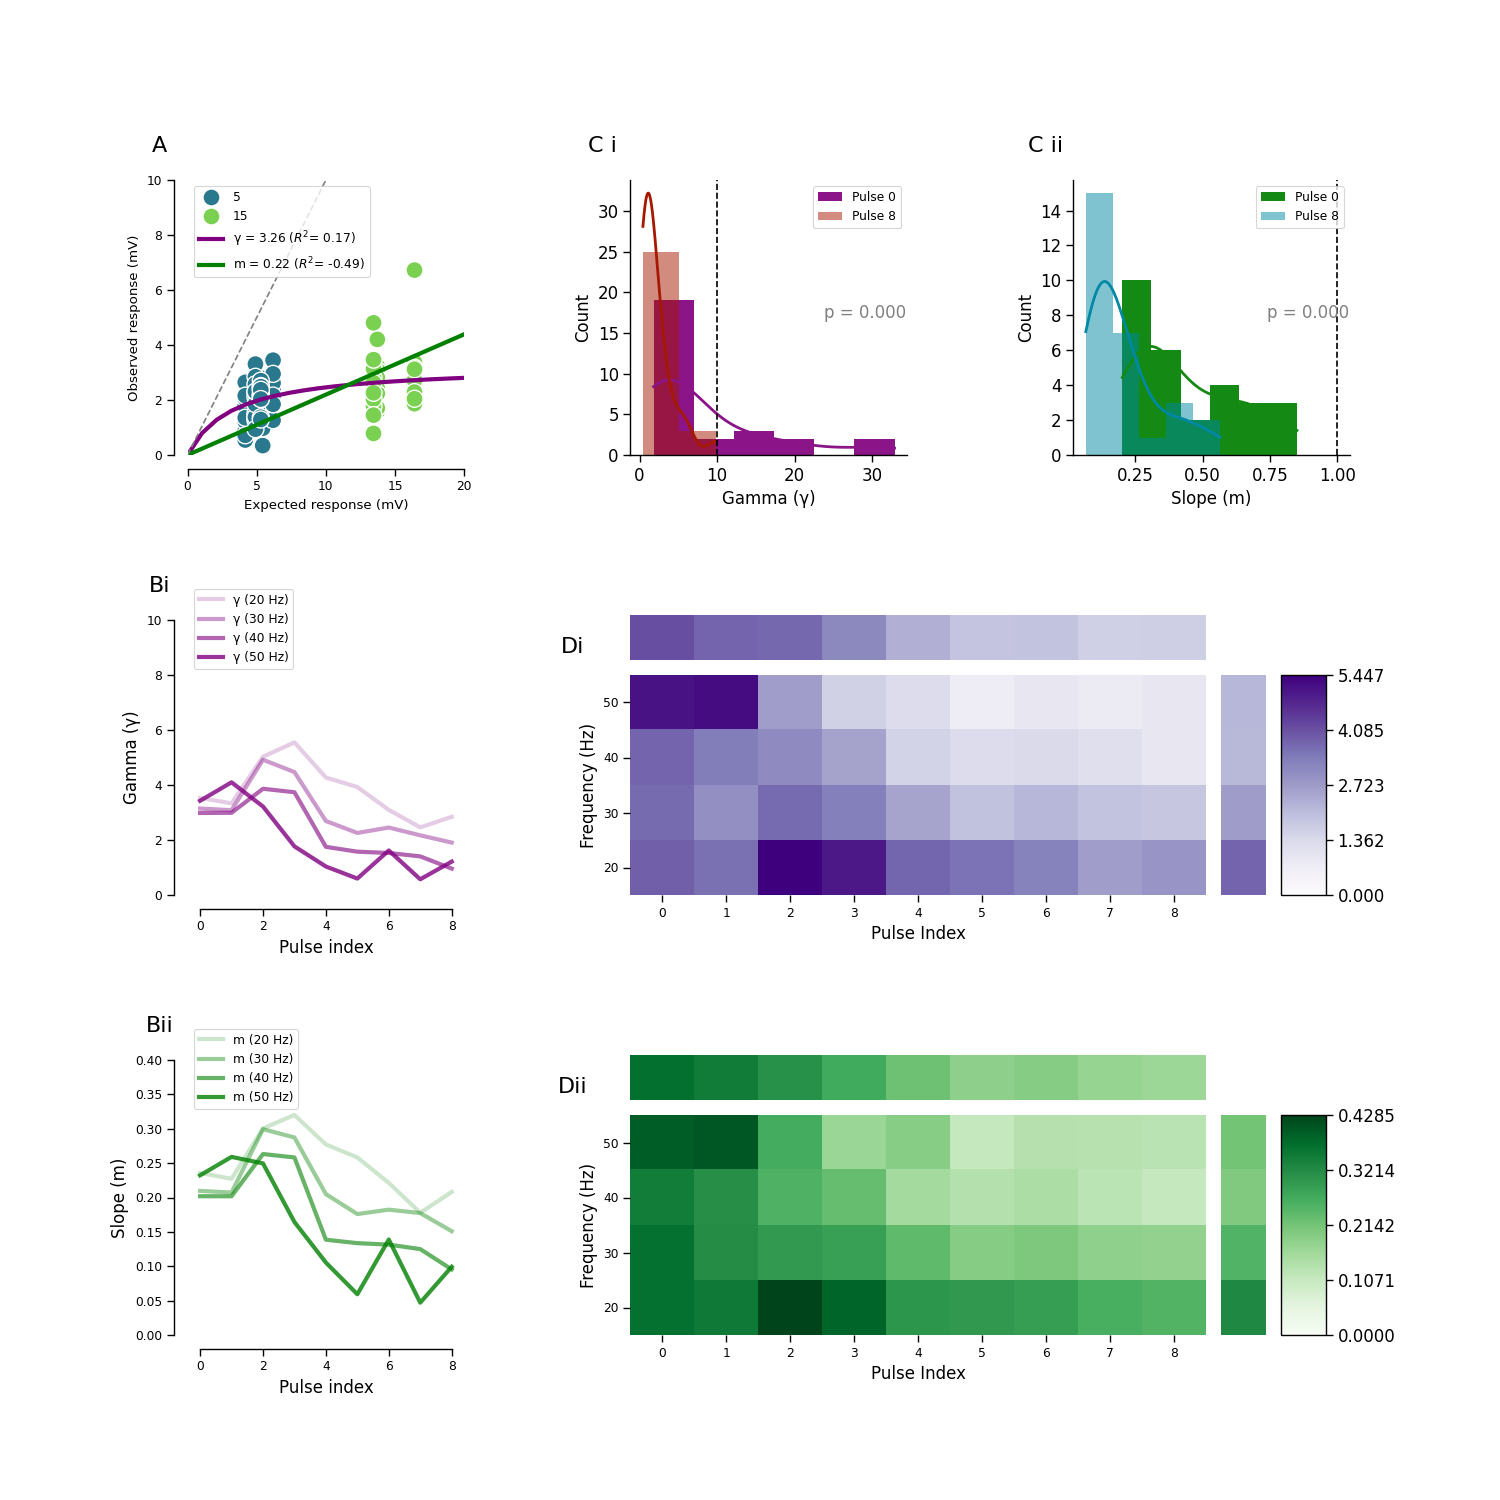

In [13]:
plt.close('all')

Fig3, ax3 = plt.subplot_mosaic([['A','Ci','Cii'],['Bi','Di','Di'],['Bii','Dii','Dii']], figsize=(15,15), )
plt.subplots_adjust(wspace=0.6, hspace=0.6)

color_pulses_lin   = mpl.colormaps['Greens']
color_pulses_gamma = mpl.colormaps['Purples']

# drop all rows where gamma is nan
fitdf_slice = fitdf[~fitdf['gamma'].isna()]
selected_cell = 3402

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3A: Scatterplot and SDN for cell = selected_cell, pulse = 0
ax3['A'].text(-0.1, 1.1, 'A', fontsize=16, ha='center', transform=ax3['A'].transAxes)
dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==0) & (sdn_df['AP']==0)]
ax3['A'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['A'], palette=color_squares)
# add gamma fit for 0th pule and all frequencies
gammatemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['gamma'].values
slopetemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['slope'].values
r2_gammatemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_sdn'].values
r2_slopetemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_lin'].values
print(gammatemp, slopetemp, r2_gammatemp, r2_slopetemp)
ax3['A'].plot(np.linspace(0,20,20), sdnfunc(np.linspace(0,20,20),gammatemp), color='purple', linewidth=3, label=f'γ = {gammatemp[0]:.2f} ($R^2$= {r2_gammatemp[0]:.2f})')
ax3['A'].plot(np.linspace(0,20,20), nosdn(np.linspace(0,20,20),slopetemp),   color='green', linewidth=3,    label=f'm = {slopetemp[0]:.2f} ($R^2$= {r2_slopetemp[0]:.2f})')
ax3['A'].plot([0,15],[0,15], color='grey', linestyle='--')

ax3['A'].set_xlabel('Expected response (mV)')
ax3['A'].set_ylabel('Observed response (mV)')
ax3['A'].legend(loc='upper left')

ax3['A'].set_xlim([0,20])
ax3['A'].set_ylim([0,10])
sns.despine(bottom=False, left=False, trim=True, offset=10, ax=ax3['A'])

# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Plot 3B: lineplot of gamma across all cells, where x-axis: pulse, y-axis: gamma, hue: stim_freq
ax3['Bi'].text(-0.1, 1.1, 'Bi', fontsize=16, ha='center', transform=ax3['Bi'].transAxes)
ax3['Bii'].text(-0.1, 1.1, 'Bii', fontsize=16, ha='center', transform=ax3['Bii'].transAxes)


for i,f in enumerate([20,30,40,50]):
    gammas = []
    slopes = []
    for p in range(9):
        dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==p)& (sdn_df['stimFreq']==f)]
        if dftemp.shape[0] == 0:
            continue
        gammatemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['gamma'].values
        slopetemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['slope'].values
        gammas.append(gammatemp)
        slopes.append(slopetemp)

    ax3['Bi'].plot(np.arange(9), np.array(gammas), color='purple', linewidth=3, label=f'γ ({f} Hz)', alpha=0.2+i*0.2)
    ax3['Bii'].plot(np.arange(9), np.array(slopes), color='green', linewidth=3, label=f'm ({f} Hz)', alpha=0.2+i*0.2)

    # set ylim
    ax3['Bi'].set_ylim([0,10])
    ax3['Bii'].set_ylim([0,0.4])

    sns.despine(bottom=False, left=False, ax=ax3['Bi'],   trim=True, offset=10)
    sns.despine(bottom=False, left=False, ax=ax3['Bii'], trim=True, offset=10)

    # legend outside
    ax3['Bi'].legend( bbox_to_anchor=(0.0, 0.8),  loc='lower left')
    ax3['Bii'].legend(bbox_to_anchor=(0.0, 0.8), loc='lower left')

    ax3['Bi'].set_xlabel('Pulse index', fontdict={'fontsize':12})
    ax3['Bi'].set_ylabel('Gamma (γ)', fontdict={'fontsize':12})
    ax3['Bii'].set_xlabel('Pulse index', fontdict={'fontsize':12})
    ax3['Bii'].set_ylabel('Slope (m)', fontdict={'fontsize':12})


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Histogram of gamma values for all the cells in the control condition
ax3['Ci'].text( -0.1, 1.1, 'C i', fontsize=16, ha='center', transform=ax3['Ci'].transAxes)
ax3['Cii'].text(-0.1, 1.1, 'C ii', fontsize=16, ha='center', transform=ax3['Cii'].transAxes)

gammadist0 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==0) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
gammadist8 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==8) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
# any gamma value above 100 can be capped at 100
cap = 50
gammadist0['gamma'] = gammadist0['gamma'].apply(lambda x: cap if x>cap else x)
gammadist8['gamma'] = gammadist8['gamma'].apply(lambda x: cap if x>cap else x)

sns.histplot(data=gammadist0, x='gamma', color='#8b1489', kde=True, ax=ax3['Ci'], alpha=1.0, edgecolor='None', binwidth=5, label='Pulse 0', line_kws={'lw': 2,})
sns.histplot(data=gammadist8, x='gamma', color='#a61900', kde=True, ax=ax3['Ci'], alpha=0.5, edgecolor='None', binwidth=5, label='Pulse 8', line_kws={'lw': 2,})

sns.histplot(data=gammadist0, x='slope', color='#148a14', kde=True, ax=ax3['Cii'], alpha=1.0, edgecolor='None', binwidth=0.1, label='Pulse 0', line_kws={'lw': 2,})
sns.histplot(data=gammadist8, x='slope', color='#0088a5', kde=True, ax=ax3['Cii'], alpha=0.5, edgecolor='None', binwidth=0.1, label='Pulse 8', line_kws={'lw': 2,})

# add a vertical line at gammma = 10 and slope = 1
ax3['Ci'].axvline(10, color='black', linestyle='--')
ax3['Cii'].axvline(1, color='black', linestyle='--')

ax3['Ci'].set_xlabel('Gamma (γ)', fontsize=12)
ax3['Ci'].set_ylabel('Count', fontsize=12)
ax3['Cii'].set_xlabel('Slope (m)', fontsize=12)
ax3['Cii'].set_ylabel('Count', fontsize=12)

sns.despine(bottom=False, left=False, ax=ax3['Ci'])
sns.despine(bottom=False, left=False, ax=ax3['Cii'])
ax3['Ci'].tick_params(axis='both', which='major', labelsize=12)
ax3['Cii'].tick_params(axis='both', which='major', labelsize=12)

ax3['Ci'].legend(loc='upper right')
ax3['Cii'].legend(loc='upper right')

# statistics on gamma and slope
# rank-order test to check if pulse 0 and pulse 8 distributions are different
_, pval_gamma = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])
_, pval_slope = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])

# stat annotate on the plot
ax3['Ci'].text(0.7, 0.5, f'p = {pval_gamma:.3f}', transform=ax3['Ci'].transAxes, fontsize=12, color='grey')
ax3['Cii'].text(0.7, 0.5, f'p = {pval_slope:.3f}', transform=ax3['Cii'].transAxes, fontsize=12, color='grey')

# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3D: Heatmap of slope
importlib.reload(plot_tools)

fitdf_slice = fitdf[(fitdf['cellID']!=1000) & (fitdf['pulse']!=1000) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])

fitdf_slice.drop(columns=['expected','observed','cellID'], inplace=True)
x = fitdf_slice.groupby(['pulse', 'stimFreq']).median().reset_index()
n = fitdf_slice.groupby(['pulse', 'stimFreq']).count().reset_index()
gammapivot = x.pivot(index='stimFreq', columns='pulse', values='gamma')
gammapivot_n = n.pivot(index='stimFreq', columns='pulse', values='gamma')
slopepivot = x.pivot(index='stimFreq', columns='pulse', values='slope')
slopepivot_n = n.pivot(index='stimFreq', columns='pulse', values='slope')
ax3['Di'], _, _, _, _ = plot_tools.ax_to_partial_dist_heatmap_ax(gammapivot, gammapivot_n, Fig3, ax3['Di'], barw=0.03, pad=0.01, shrink=0.8, palette='Purples', force_vmin_to_zero=True, annotate=False)
ax3['Dii'], _, _, _, _ = plot_tools.ax_to_partial_dist_heatmap_ax(slopepivot, slopepivot_n, Fig3, ax3['Dii'], barw=0.03, pad=0.01, shrink=0.8, palette='Greens', force_vmin_to_zero=True, annotate=False)
ax3['Di'].text( -0.1, 1.1, 'Di', fontsize=16, ha='center', transform=ax3['Di'].transAxes)
ax3['Dii'].text(-0.1, 1.1, 'Dii', fontsize=16, ha='center', transform=ax3['Dii'].transAxes)


# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Voltage clamp plots

## save fig 3
Fig3.savefig(paper_figure_export_location / 'Figure3.png', dpi=300, bbox_inches='tight')
Fig3.savefig(paper_figure_export_location / 'Figure3.svg', dpi=300, bbox_inches='tight')

### E-I delays from VC data

In [14]:
vc_FS_shortdf_slice = utils.expand_list_column(vc_FS_shortdf_slice, 'pulseTimes', 'stimOnset_')

(1502, 172)
new columns:  ['stimOnset_0', 'stimOnset_1', 'stimOnset_2', 'stimOnset_3', 'stimOnset_4', 'stimOnset_5', 'stimOnset_6', 'stimOnset_7', 'stimOnset_8']
(1502, 9) (1502, 181)


In [15]:
idvars = ['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','trialID']
valvars1 = [f'stimOnset_{i}' for i in freq_sweep_pulses] 
valvars2 = [f'peaktime_{i}' for i in freq_sweep_pulses]
df1 = vc_FS_shortdf_slice.melt(id_vars=idvars, 
              value_vars=valvars1,
              var_name='stim', value_name='stim_onset')
df2 = vc_FS_shortdf_slice.melt(id_vars=idvars, 
              value_vars=valvars2, 
              var_name='peak', value_name='peak_onset')

# make a new column that is pulse number taken from the suffix in the prop column
df1['pulse'] = df1['stim'].apply(lambda x: int(x.split('_')[-1]))
# divide stim_onset column by 2e4
df1['stim_onset'] = df1['stim_onset'] / 2e4
df2['pulse'] = df2['peak'].apply(lambda x: int(x.split('_')[-1]))
# concat df1 and df2 on axis1
df3 = pd.merge(df1, df2, on=['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','pulse','trialID'], )
df3['time_to_peak'] = df3['peak_onset'] - df3['stim_onset']
# drop columns stim and peak
df3.drop(columns=['stim','peak'], inplace=True)
print(df3.shape)
# drop NaNs in time_to_peak
df3 = df3.dropna(subset=['time_to_peak'])
print(df3.shape)
df3.drop(columns=['trialID'], inplace=True)
# make numSq int
df3['numSq'] = df3['numSq'].astype('int')
df4 = df3.groupby(['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','pulse']).mean().reset_index()
print(df4.shape)
# pivot w.r.t clampPotential
delay_df = df4.pivot(index=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], columns='clampPotential', values='time_to_peak').reset_index()
print(delay_df.shape)
# drop NaNs from df4pivot from columns -70 and 0
delay_df = delay_df.dropna(subset=[-70,0])
# subtract -70 from 0
delay_df['delayEI'] = 1000* (delay_df[0] - delay_df[-70])
print(delay_df.shape)

# save delay_df
delay_df.to_hdf(paper_figure_export_location / "Figure3_delay_df_VC_FS.h5", key='data')

(13518, 12)
(13518, 12)
(5121, 11)
(3456, 9)
(1665, 10)


C:\Users\adity\AppData\Local\Temp\ipykernel_20792\3796652476.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  delay_df.to_hdf(paper_figure_export_location / "Figure3_delay_df_VC_FS.h5", key='data')
C:\Users\adity\AppData\Local\Temp\ipykernel_20792\3796652476.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  delay_df.to_hdf(paper_figure_export_location / "Figure3_delay_df_VC_FS.h5", key='data')


In [16]:
delay_df.sample(10)

clampPotential  cellID  stimFreq  numSq  patternList  pulseWidth  intensity  \
2371              6201        20      1           27           2        100   
1921              1931        30      5           46           5        100   
1366              1531        50     15           52           2        100   
492                111        50      5           47           2        100   
1354              1531        50      5           50           5        100   
628               1491        50      5           46           5        100   
423                111        20      5           48           2        100   
1407              1531        50     15           55           5        100   
612               1491        20     15           55           5        100   
610               1491        20     15           53           5        100   

clampPotential  pulse       -70         0    delayEI  
2371                4  0.067400  0.128050  60.650000  
1921                4  0.009283  0.008125  -1.158333  
1366                7  0.011983  0.012875   0.891667  
492                 6  0.009800  0.008650  -1.150000  
1354                4  0.012050  0.014850   2.800000  
628                 7  0.010967  0.011733   0.766667  
423                 0  0.006767  0.012867   6.100000  
1407                3  0.011700  0.016425   4.725000  
612                 0  0.010767  0.012067   1.300000  
610                 7  0.011250  0.010417  -0.833333

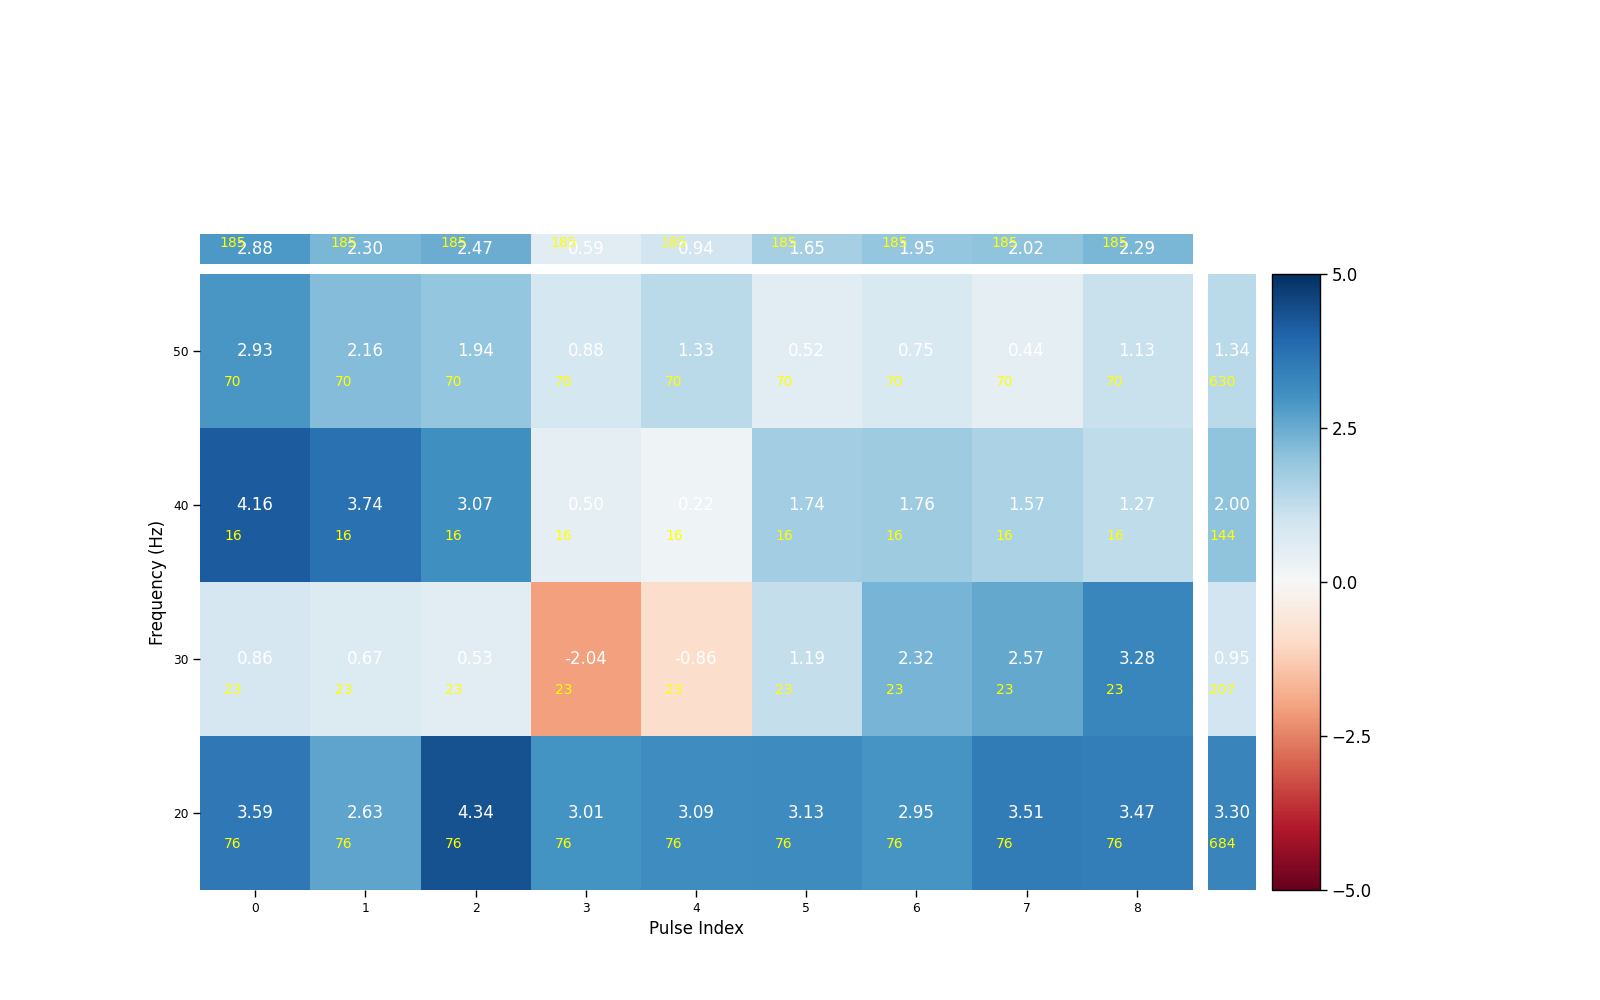

In [17]:
# plot heatmap of delay
Fig3s1, ax3s1 = plt.subplots(1,1, figsize=(16,10))
x       = delay_df.groupby(['pulse', 'stimFreq']).mean().reset_index()
xpivot  = x.pivot(index='stimFreq', columns='pulse', values='delayEI')
# print a matrix of number of trials for each condition
num_trials  = delay_df.groupby(['pulse', 'stimFreq']).count().reset_index()
npivot      = num_trials.pivot(index='stimFreq', columns='pulse', values='delayEI')
plot_tools.ax_to_partial_dist_heatmap_ax(xpivot, npivot, Fig3s1, ax3s1, barw=0.03, pad=0.01, shrink=0.8, palette='RdBu', force_vmin_to_zero=False, centralize_colorscale=True, annotate=True)
# save fig
Fig3s1.savefig(paper_figure_export_location / 'Figure3s1_EIdelay_heatmap.png', dpi=300, bbox_inches='tight')
Fig3s1.savefig(paper_figure_export_location / 'Figure3s1_EIdelay_heatmap.svg', dpi=300, bbox_inches='tight')

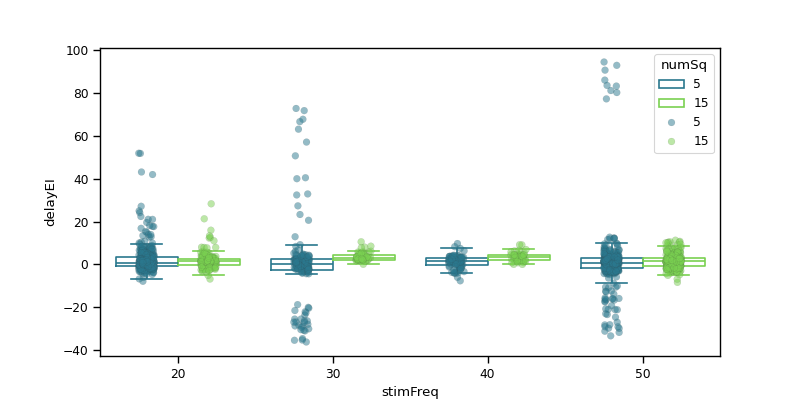

In [18]:
# box plot of delayEI across numSq and stimFreq
fig3s2, ax3s2 = plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data=delay_df, x='stimFreq', y='delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2, palette=color_squares, fliersize=0, fill=False)
sns.stripplot(data=delay_df, x='stimFreq', y='delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2, palette=color_squares, linewidth=0.1, alpha=0.5)
#save fig
fig3s2.savefig(paper_figure_export_location / 'Figure3s2_EIdelay_vsfreq_vsnumSq_boxstripplot.png', dpi=300, bbox_inches='tight')
fig3s2.savefig(paper_figure_export_location / 'Figure3s2_EIdelay_vsfreq_vsnumSq_boxstripplot.svg', dpi=300, bbox_inches='tight')

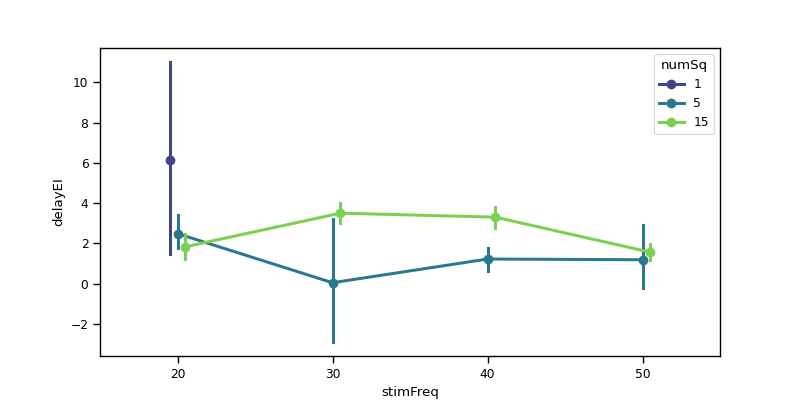

In [19]:
# box plot of delayEI across numSq and stimFreq
fig3s3, ax3s3 = plt.subplots(1,1, figsize=(8,4))
sns.pointplot(data=delay_df, x='stimFreq', y='delayEI', hue='numSq', hue_order=[1,5,15], ax=ax3s3, palette=color_squares, dodge=0.1)
#save fig
fig3s3.savefig(paper_figure_export_location / 'Figure3s3_EIdelay_vsfreq_vsnumSq_pointplot.png', dpi=300, bbox_inches='tight')
fig3s3.savefig(paper_figure_export_location / 'Figure3s3_EIdelay_vsfreq_vsnumSq_pointplot.svg', dpi=300, bbox_inches='tight')

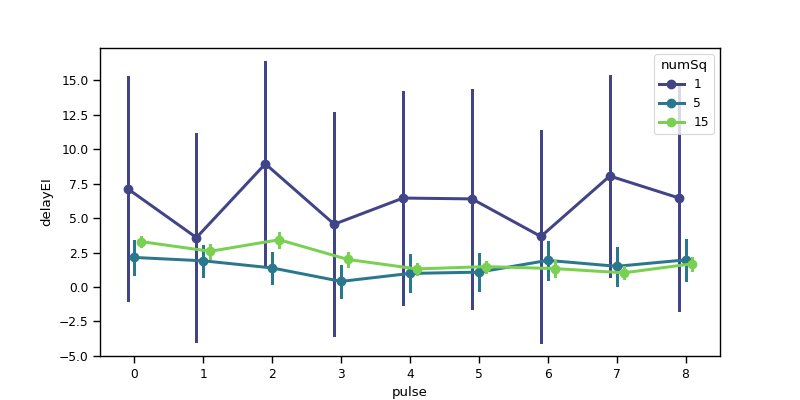

In [20]:
# box plot of delayEI across numSq and stimFreq
fig3s4, ax3s4 = plt.subplots(1,1, figsize=(8,4))
sns.pointplot(data=delay_df, x='pulse', y='delayEI', hue='numSq', hue_order=[1,5,15], ax=ax3s4, palette=color_squares, errorbar='se', dodge=0.2)
# save fig
fig3s4.savefig(paper_figure_export_location / 'Figure3s4_EIdelay_vspulse_vsnumsq.png', dpi=300, bbox_inches='tight')
fig3s4.savefig(paper_figure_export_location / 'Figure3s4_EIdelay_vspulse_vsnumsq.svg', dpi=300, bbox_inches='tight')

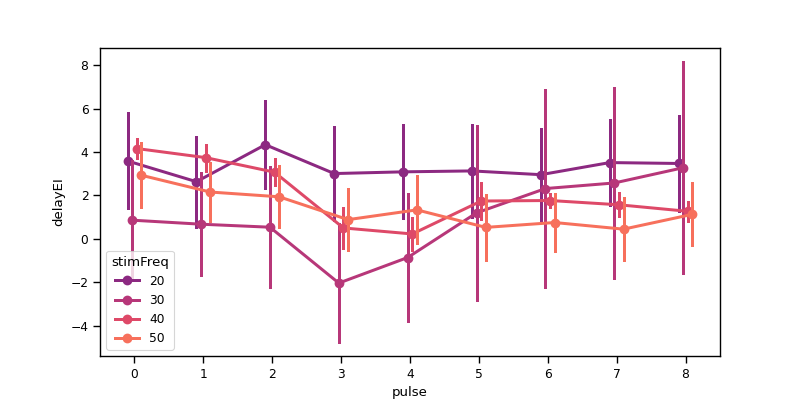

In [21]:
# box plot of delayEI across numSq and stimFreq
fig3s5, ax3s5 = plt.subplots(1,1, figsize=(8,4))
sns.pointplot(data=delay_df, x='pulse', y='delayEI', hue='stimFreq', hue_order=[20,30,40,50], ax=ax3s5, palette=color_freq, errorbar='se', dodge=0.2)
# save fig
fig3s5.savefig(paper_figure_export_location / 'Figure3s5_EIdelay_vspulse_vsstimFreq.png', dpi=300, bbox_inches='tight')
fig3s5.savefig(paper_figure_export_location / 'Figure3s5_EIdelay_vspulse_vsstimFreq.svg', dpi=300, bbox_inches='tight')

## EbyI ratio from VC data

In [22]:
idvars = ['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','trialID']
valvars2 = [f'PSC_{i}' for i in freq_sweep_pulses]
df2 = vc_FS_shortdf_slice.melt(id_vars=idvars, 
              value_vars=valvars2, 
              var_name='pulse', value_name='PSC')
df2['pulse'] = df2['pulse'].apply(lambda x: int(x.split('_')[-1]))
df2 = df2.dropna(subset=['PSC'])
df2.drop(columns=['trialID'], inplace=True)
df2['numSq'] = df2['numSq'].astype('int')
df4 = df2.groupby(['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','pulse']).mean().reset_index()
print(df4.shape)
ebyi_df = df4.pivot(index=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], columns='clampPotential', values='PSC').reset_index()
ebyi_df = ebyi_df.dropna(subset=[-70,0])
# ratio of -70 and 0
ebyi_df['EbyI'] = ( - ebyi_df[-70] / ebyi_df[0])
print(ebyi_df.shape)

# save ebyi_df
ebyi_df.to_hdf(paper_figure_export_location / "Figure3_ebyi_df_VC_FS.h5", key='data')

(5121, 9)
(1665, 10)


C:\Users\adity\AppData\Local\Temp\ipykernel_20792\3199071260.py:19: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  ebyi_df.to_hdf(paper_figure_export_location / "Figure3_ebyi_df_VC_FS.h5", key='data')
C:\Users\adity\AppData\Local\Temp\ipykernel_20792\3199071260.py:19: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  ebyi_df.to_hdf(paper_figure_export_location / "Figure3_ebyi_df_VC_FS.h5", key='data')


In [23]:
ebyi_df

clampPotential  cellID  stimFreq  numSq  patternList  pulseWidth  intensity  \
405                111        20      5           46           2        100   
406                111        20      5           46           2        100   
407                111        20      5           46           2        100   
408                111        20      5           46           2        100   
409                111        20      5           46           2        100   
...                ...       ...    ...          ...         ...        ...   
3451              7492        50     15           55           2        100   
3452              7492        50     15           55           2        100   
3453              7492        50     15           55           2        100   
3454              7492        50     15           55           2        100   
3455              7492        50     15           55           2        100   

clampPotential  pulse        -70          0      EbyI  
405                 0 -25.894341  90.213433  0.287034  
406                 1 -40.901156  59.832133  0.683598  
407                 2 -43.980818  86.930224  0.505932  
408                 3 -38.603649  59.946906  0.643964  
409                 4 -32.698251  60.566469  0.539874  
...               ...        ...        ...       ...  
3451                4 -75.669088  57.568644  1.314415  
3452                5 -66.427795  51.932434  1.279120  
3453                6 -59.258120  20.156596  2.939887  
3454                7 -40.077075  55.296672  0.724765  
3455                8 -68.955602  80.532735  0.856243  

[1665 rows x 10 columns]

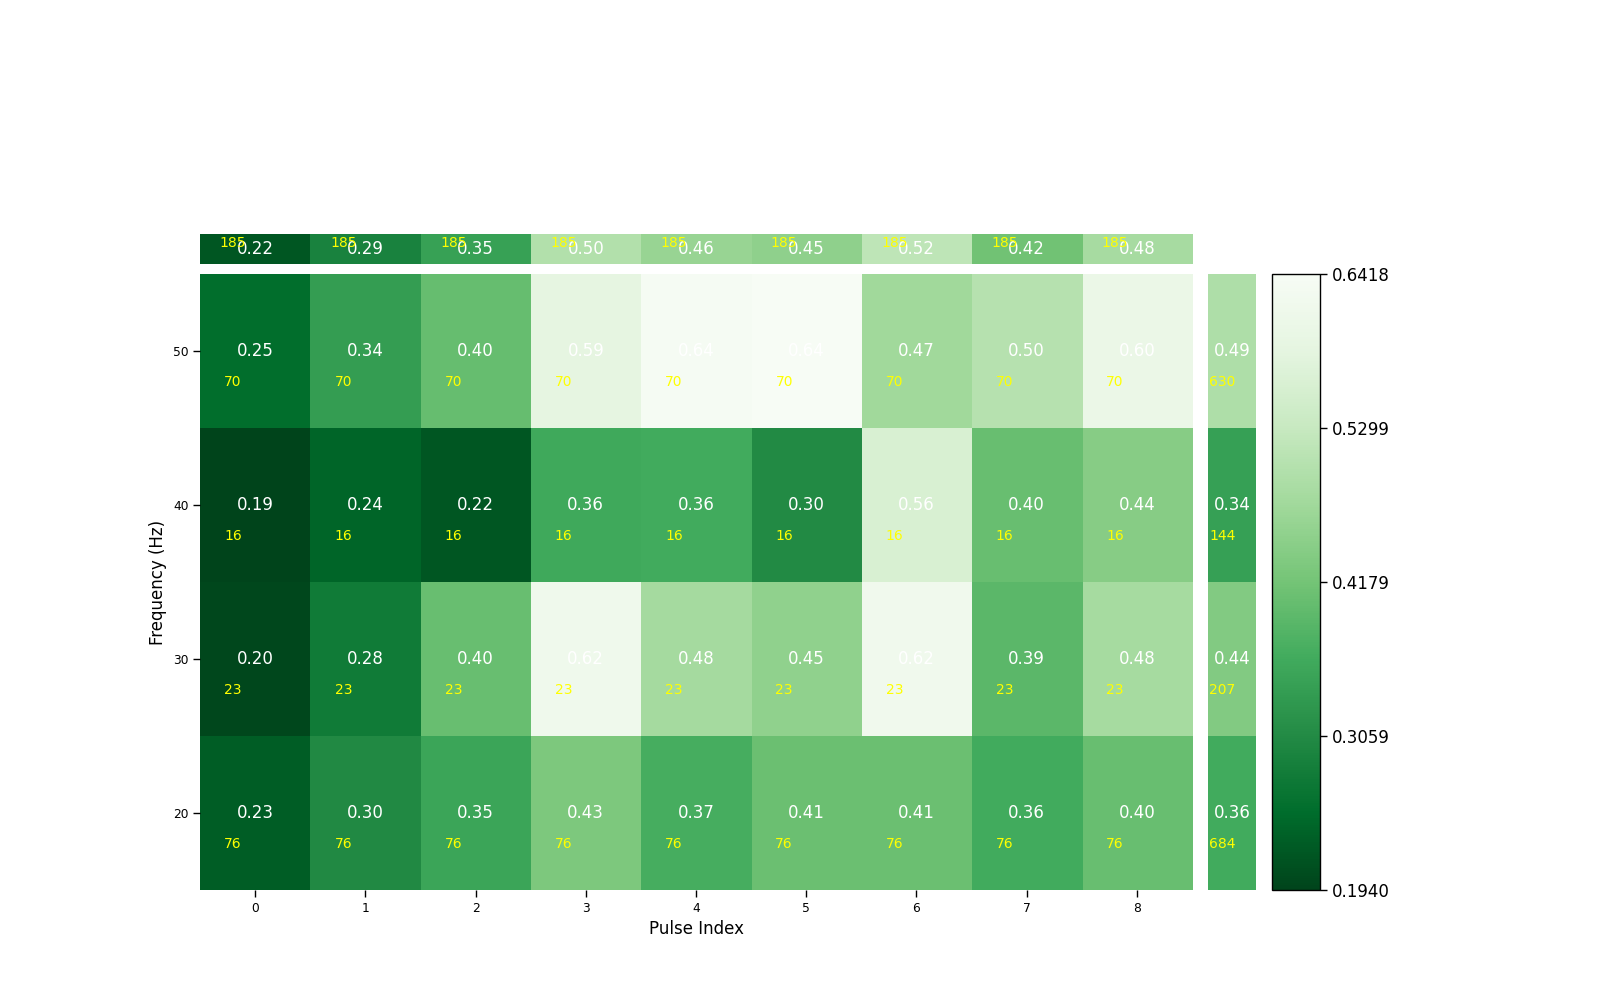

In [24]:
Fig3s6, ax3s6 = plt.subplots(1,1, figsize=(16,10))
x = ebyi_df.groupby(['pulse', 'stimFreq']).median().reset_index()
xpivot = x.pivot(index='stimFreq', columns='pulse', values='EbyI')
# print a matrix of number of trials for each condition
num_trials = ebyi_df.groupby(['pulse', 'stimFreq']).count().reset_index()
npivot = num_trials.pivot(index='stimFreq', columns='pulse', values='EbyI')
plot_tools.ax_to_partial_dist_heatmap_ax(xpivot, npivot, Fig3s6, ax3s6, barw=0.03, pad=0.01, shrink=0.8, palette='Greens_r', force_vmin_to_zero=False, centralize_colorscale=False, annotate=True)
# save fig
Fig3s6.savefig(paper_figure_export_location / 'Figure3s6_EbyI_heatmap_median.png', dpi=300, bbox_inches='tight')
Fig3s6.savefig(paper_figure_export_location / 'Figure3s6_EbyI_heatmap_median.svg', dpi=300, bbox_inches='tight')

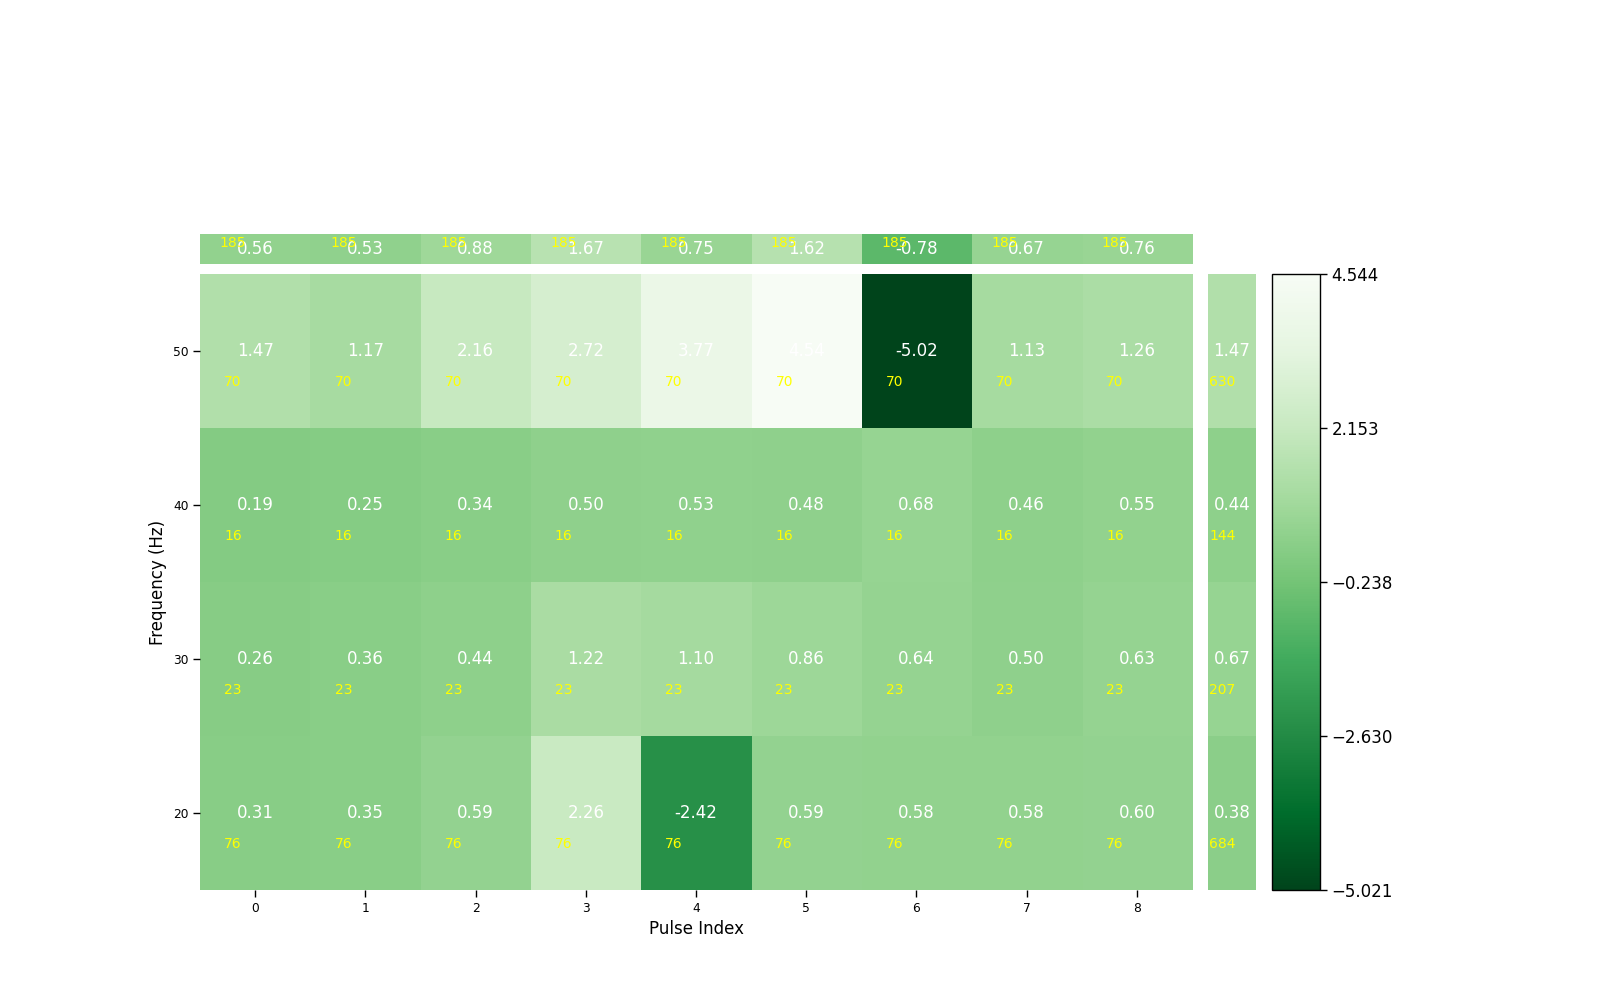

In [25]:
Fig3s7, ax3s7 = plt.subplots(1,1, figsize=(16,10))
x = ebyi_df.groupby(['pulse', 'stimFreq']).mean().reset_index()
xpivot = x.pivot(index='stimFreq', columns='pulse', values='EbyI')
# print a matrix of number of trials for each condition
num_trials = ebyi_df.groupby(['pulse', 'stimFreq']).count().reset_index()
npivot = num_trials.pivot(index='stimFreq', columns='pulse', values='EbyI')
plot_tools.ax_to_partial_dist_heatmap_ax(xpivot, npivot, Fig3s7, ax3s7, barw=0.03, pad=0.01, shrink=0.8, palette='Greens_r', force_vmin_to_zero=False, centralize_colorscale=False, annotate=True)
# save fig
Fig3s7.savefig(paper_figure_export_location / 'Figure3s7_EbyI_heatmap_mean.png', dpi=300, bbox_inches='tight')
Fig3s7.savefig(paper_figure_export_location / 'Figure3s7_EbyI_heatmap_mean.svg', dpi=300, bbox_inches='tight')

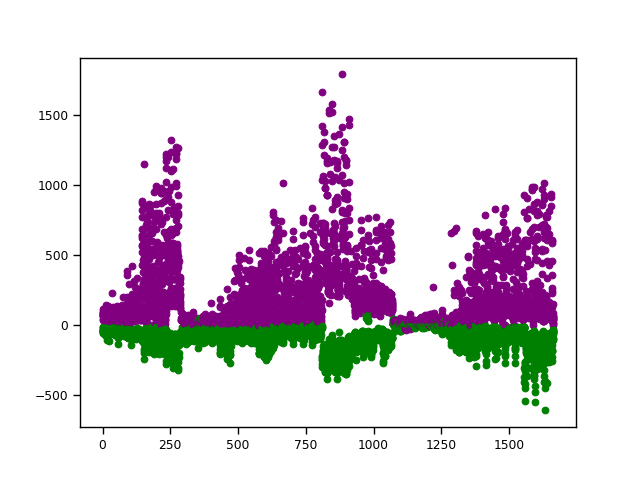

In [26]:
fig3s8, ax3s8 = plt.subplots(1,1, figsize=(16,6))
counter = 0
for cell in np.sort(df2['cellID'].unique()):
    for pat in np.sort(df2['patternList'].unique()):
        for f in np.sort(df2['stimFreq'].unique()):
            for p in np.sort(df2['pulse'].unique()):
                for pw in np.sort(df2['pulseWidth'].unique()):
                    for inten in np.sort(df2['intensity'].unique()):
                        dftemp = df2[(df2['cellID']==cell) & (df2['patternList']==pat) & (df2['stimFreq']==f) & (df2['pulse']==p) & (df2['pulseWidth']==pw) & (df2['intensity']==inten)]
                        if dftemp.shape[0] == 0:
                            continue
                        excn = dftemp[dftemp['clampPotential']==-70].dropna(subset=['PSC'])
                        inhn = dftemp[dftemp['clampPotential']==0].dropna(subset=['PSC'])
                        if (excn.shape[0] == 0) | (inhn.shape[0] == 0):
                            continue
                        exc, inh = excn['PSC'].values, inhn['PSC'].values
                        exc = np.where(exc <-1000, exc/20, exc)
                        for i in exc:
                            ax3s8.scatter(counter, i, color='green')
                        for i in inh:
                            ax3s8.scatter(counter, i, color='purple')
                        counter +=1

fig3s8.savefig(paper_figure_export_location / 'Figure3s8_EbyI_scatter_trial_by_trial.png', dpi=300, bbox_inches='tight')
fig3s8.savefig(paper_figure_export_location / 'Figure3s8_EbyI_scatter_trial_by_trial.svg', dpi=300, bbox_inches='tight')

In [39]:
trialwise_dict = []
for cell in np.sort(df2['cellID'].unique()):
    for pat in np.sort(df2['patternList'].unique()):
        for f in np.sort(df2['stimFreq'].unique()):
            for p in np.sort(df2['pulse'].unique()):
                for pw in np.sort(df2['pulseWidth'].unique()):
                    for inten in np.sort(df2['intensity'].unique()):
                        dftemp = df2[(df2['cellID']==cell) & (df2['patternList']==pat) & (df2['stimFreq']==f) & (df2['pulse']==p) & (df2['pulseWidth']==pw) & (df2['intensity']==inten)]
                        if dftemp.shape[0] == 0:
                            continue
                        excn = dftemp[dftemp['clampPotential']==-70].dropna(subset=['PSC'])
                        inhn = dftemp[dftemp['clampPotential']==0].dropna(subset=['PSC'])
                        numSq = dftemp['numSq'].values[0]
                        if (excn.shape[0] == 0) | (inhn.shape[0] == 0):
                            continue
                        exc, inh = excn['PSC'].values, inhn['PSC'].values
                        exc = np.where(exc <-1000, exc/20, exc)
                        max_exc = np.max(exc)
                        trialwise_dict.append({'cellID':cell, 'patternList':pat, 'numSq':numSq,'stimFreq':f, 'pulse':p, 'pulseWidth':pw, 'intensity':inten, 'max_exc':max_exc, 'exc':exc, 'inh':inh})

trialwise_df = pd.DataFrame(trialwise_dict)
# step 1: add a column that gives the absolute descending order of max_exc
trialwise_df['max_exc_rank'] = trialwise_df['max_exc'].rank(ascending=False)
# step2: explode exc and inh columns
trialwise_df = utils.expand_list_column(trialwise_df, 'exc', 'exc')
trialwise_df = utils.expand_list_column(trialwise_df, 'inh', 'inh')
# drop exc and inh columns
trialwise_df.drop(columns=['exc','inh'], inplace=True)

(1665, 11)
new columns:  ['exc0', 'exc1', 'exc2']
(1665, 3) (1665, 14)
(1665, 14)
new columns:  ['inh0', 'inh1', 'inh2']
(1665, 3) (1665, 17)


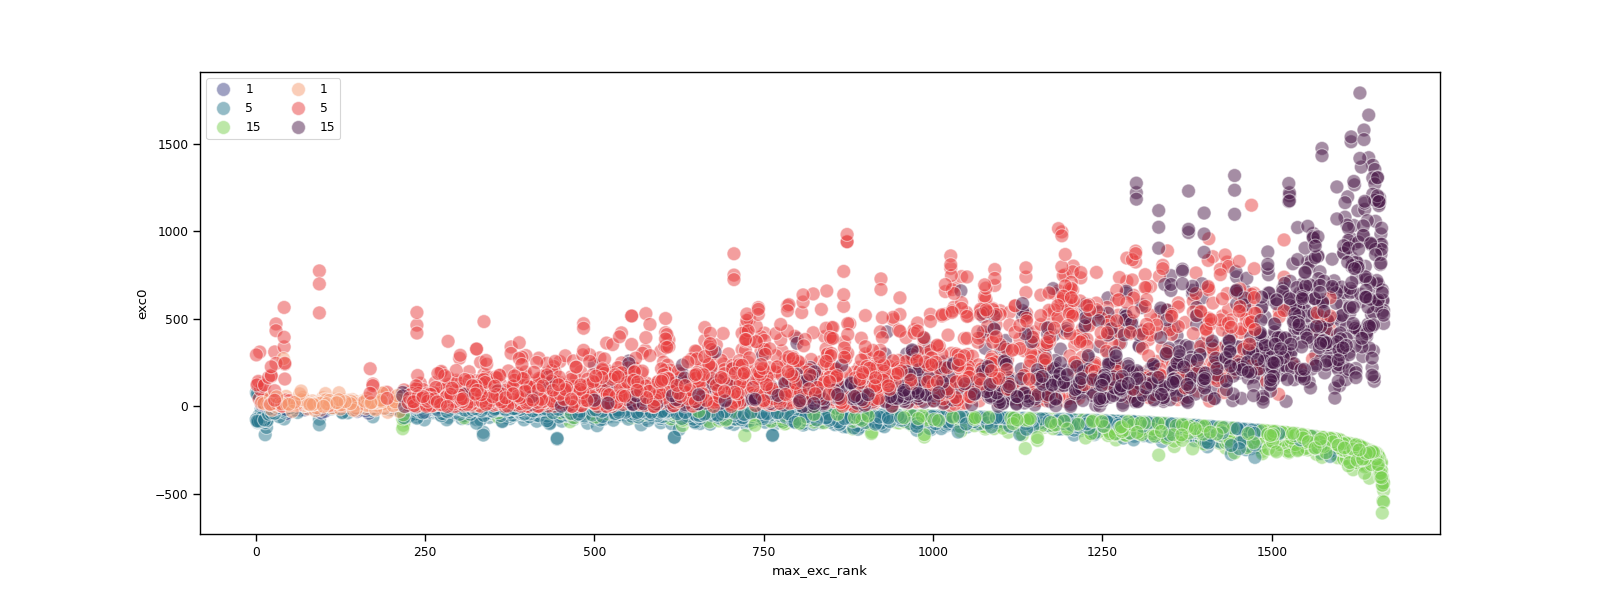

In [55]:
fig3s8b, ax3s8b = plt.subplots(1,1, figsize=(16,6))
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc0', hue='numSq', s=100, alpha=0.5, palette=color_squares, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc1', hue='numSq', s=100, alpha=0.5, palette=color_squares, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc2', hue='numSq', s=100, alpha=0.5, palette=color_squares, ax=ax3s8b)

sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh0', hue='numSq', s=100, alpha=0.5, palette=color_squares_r, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh1', hue='numSq', s=100, alpha=0.5, palette=color_squares_r, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh2', hue='numSq', s=100, alpha=0.5, palette=color_squares_r, ax=ax3s8b)

ax3s8b.legend(loc='upper left', ncols=2)

fig3s8b.savefig(paper_figure_export_location / 'Figure3s8b_EbyI_scatter_trial_by_trial_vsnumSq.png', dpi=300, bbox_inches='tight')
fig3s8b.savefig(paper_figure_export_location / 'Figure3s8b_EbyI_scatter_trial_by_trial_vsnumSq.svg', dpi=300, bbox_inches='tight')

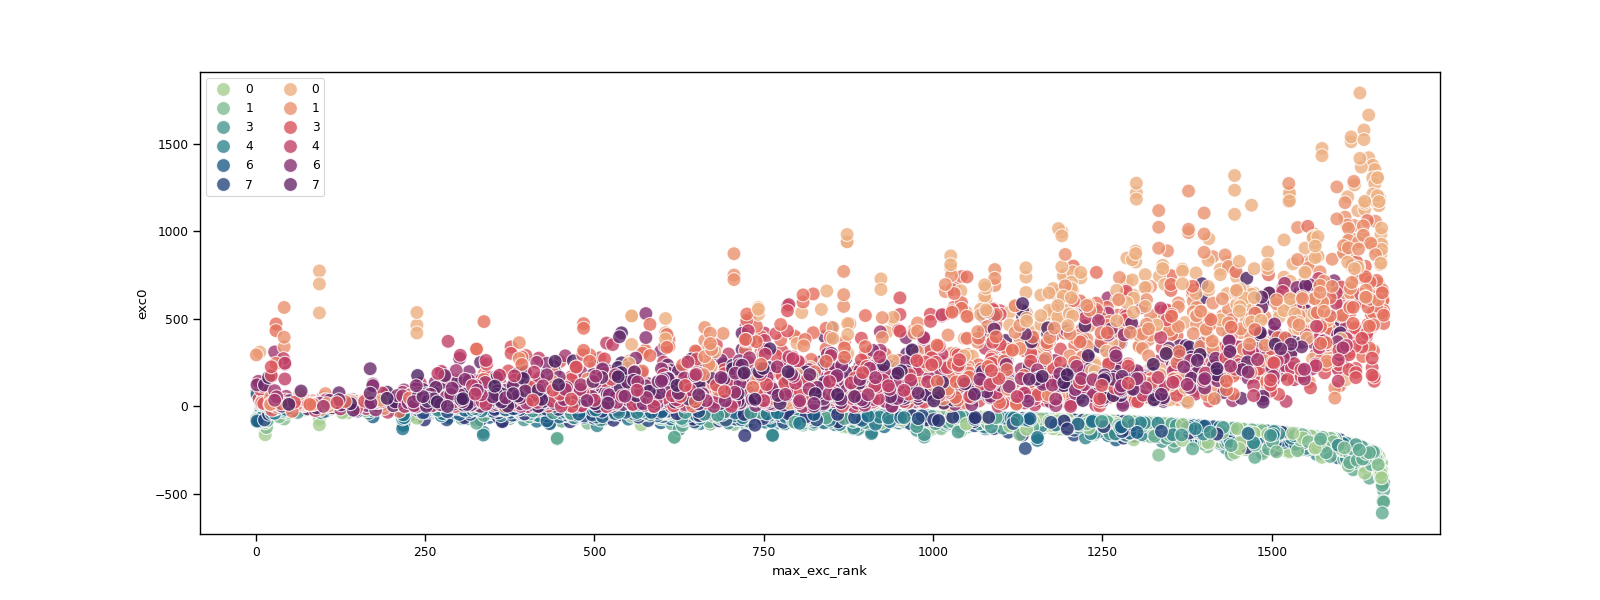

In [57]:
fig3s8c, ax3s8c = plt.subplots(1,1, figsize=(16,6))
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc0', hue='pulse', s=100, alpha=0.8, palette=crest, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc1', hue='pulse', s=100, alpha=0.8, palette=crest, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc2', hue='pulse', s=100, alpha=0.8, palette=crest, ax=ax3s8c)

sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh0', hue='pulse', s=100, alpha=0.8, palette=flare, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh1', hue='pulse', s=100, alpha=0.8, palette=flare, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh2', hue='pulse', s=100, alpha=0.8, palette=flare, ax=ax3s8c)

ax3s8c.legend(loc='upper left', ncols=2)

fig3s8c.savefig(paper_figure_export_location / 'Figure3s8c_EbyI_scatter_trial_by_trial_vspulse.png', dpi=300, bbox_inches='tight')
fig3s8c.savefig(paper_figure_export_location / 'Figure3s8c_EbyI_scatter_trial_by_trial_vspulse.svg', dpi=300, bbox_inches='tight')

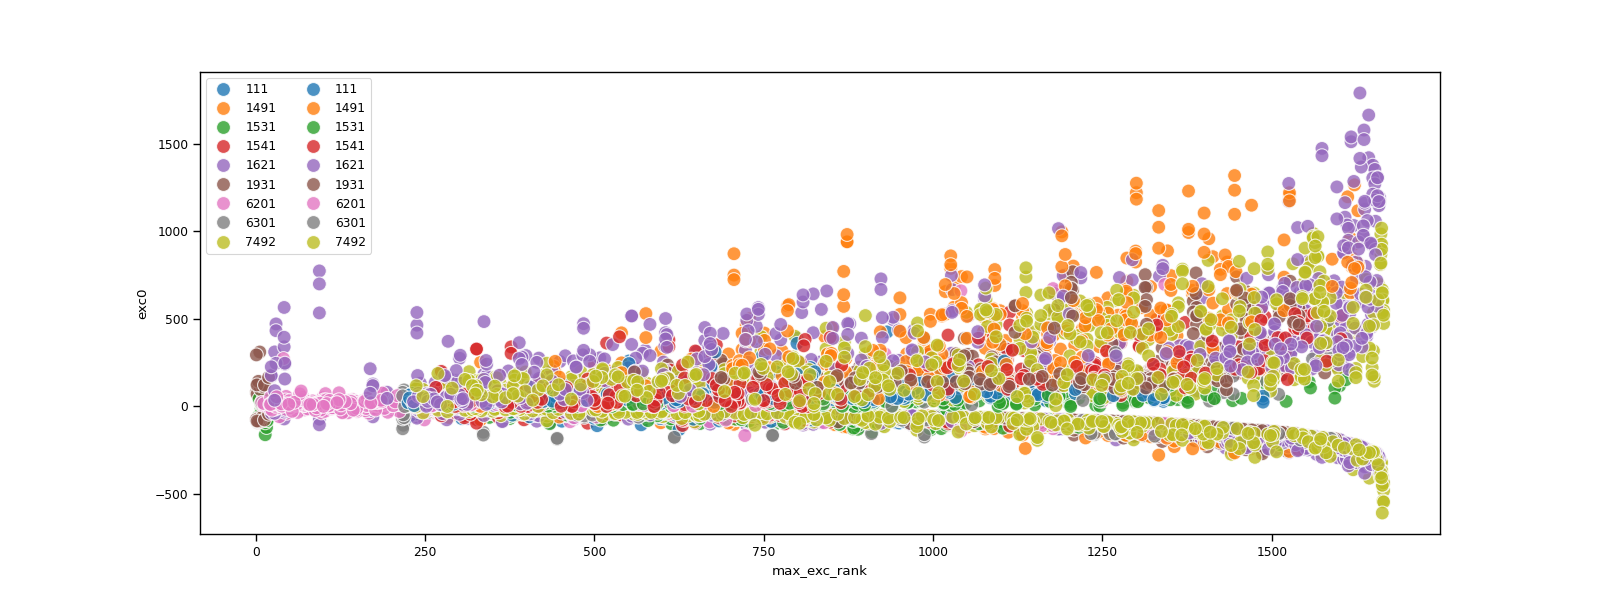

In [60]:
fig3s8d, ax3s8d = plt.subplots(1,1, figsize=(16,6))
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc0', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc1', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc2', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d)

sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh0', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh1', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh2', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d)

ax3s8d.legend(loc='upper left', ncols=2)

fig3s8d.savefig(paper_figure_export_location / 'Figure3s8d_EbyI_scatter_trial_by_trial_vscellID.png', dpi=300, bbox_inches='tight')
fig3s8d.savefig(paper_figure_export_location / 'Figure3s8d_EbyI_scatter_trial_by_trial_vscellID.svg', dpi=300, bbox_inches='tight')

In [61]:
def linear_func(x, m, c):
    return m*x + c

c:\venvs\venv-ephys\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\venvs\venv-ephys\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\venvs\venv-ephys\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\venvs\venv-ephys\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\venvs\venv-ephys\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
 

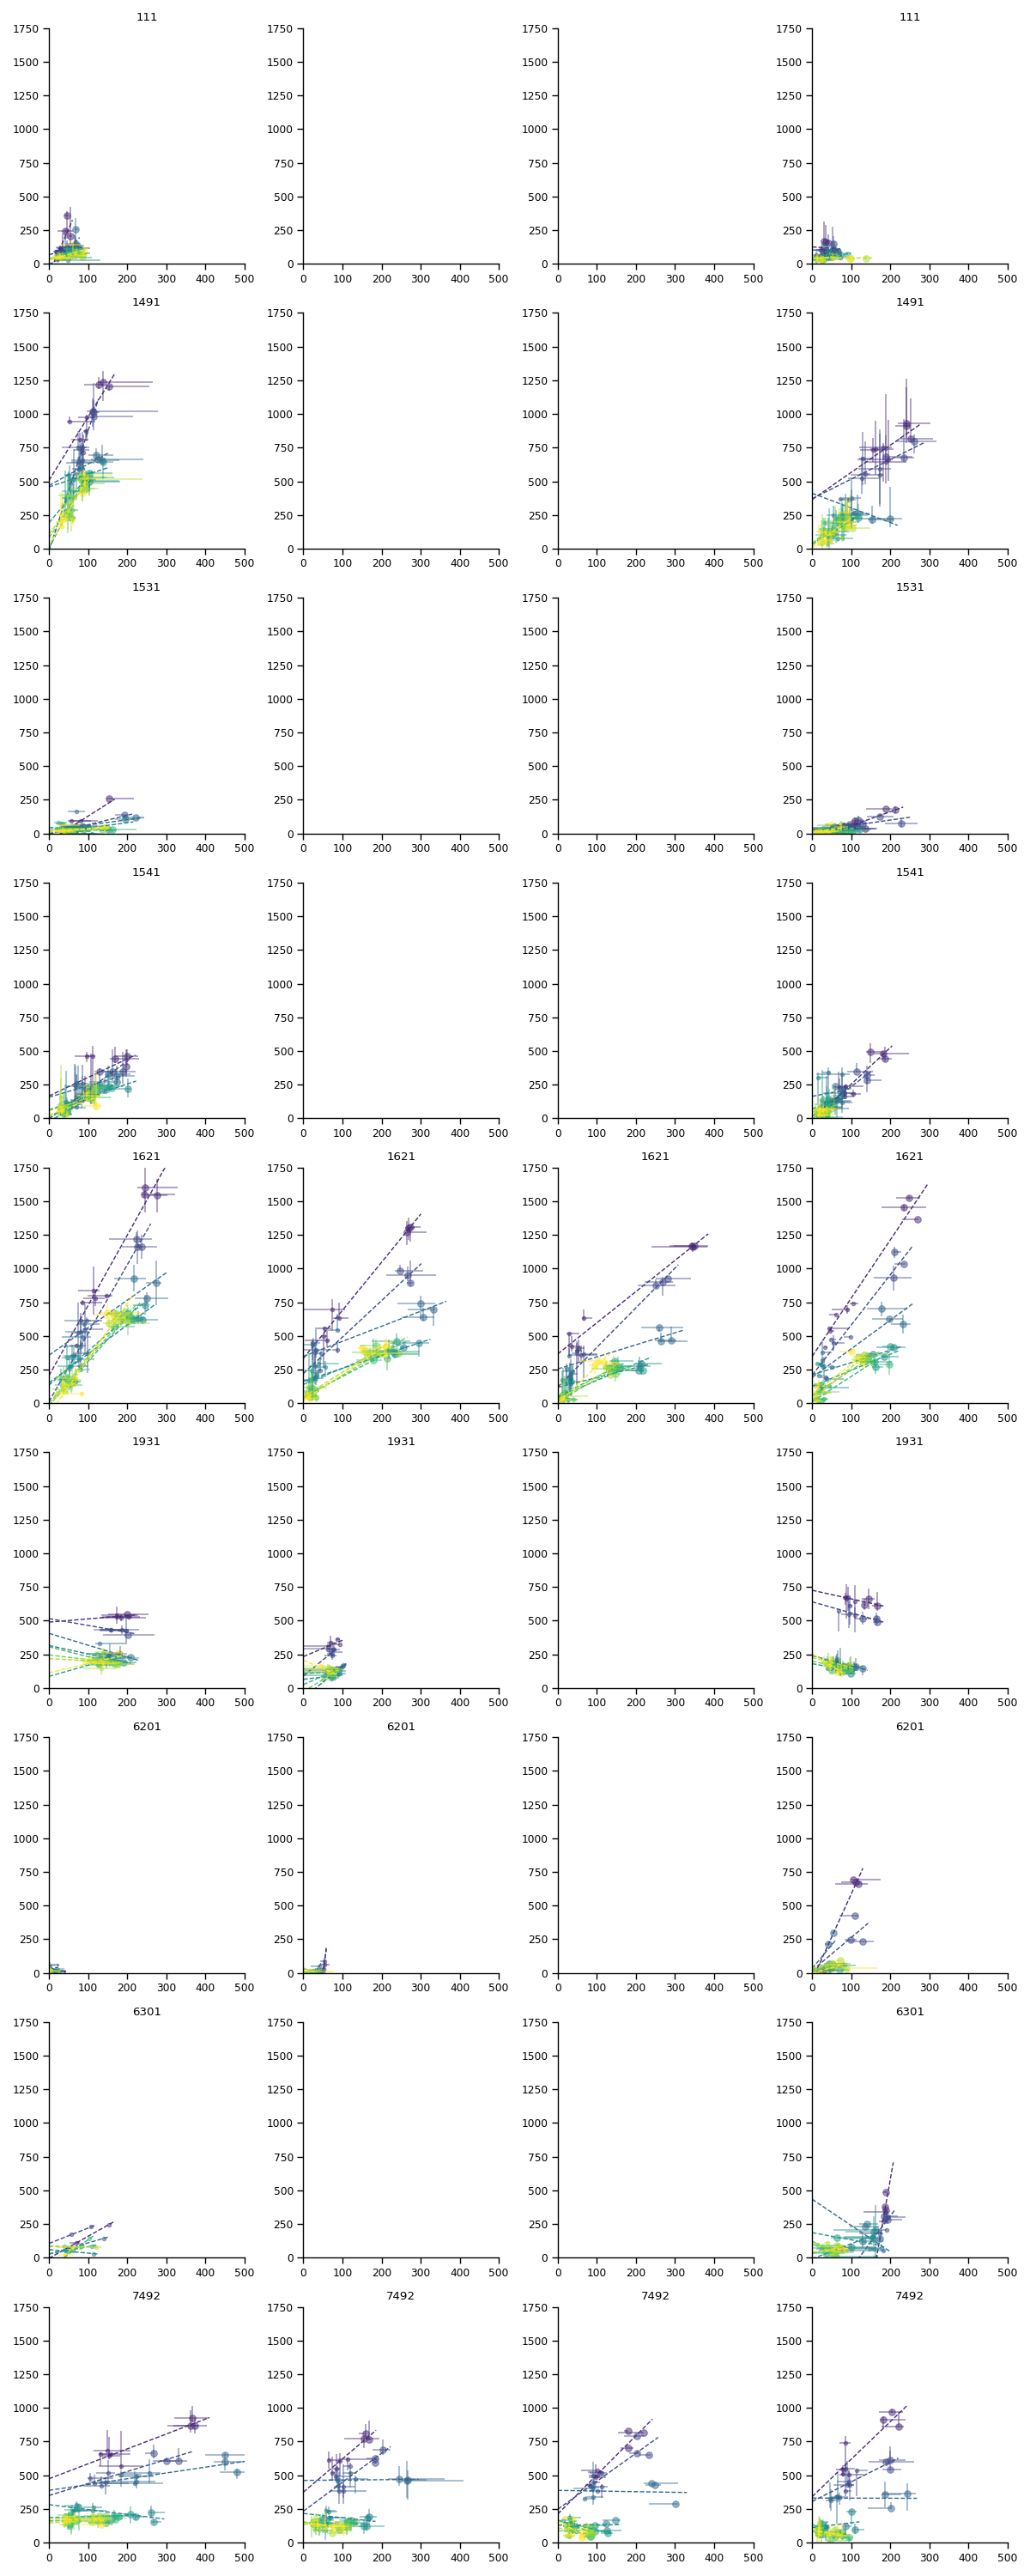

In [62]:
cells = [ 111, 1491, 1531, 1541, 1621, 1931, 6201, 6301,7492] # VC cells with at least one freq data
freqs = np.sort(df2['stimFreq'].unique())
fig3s9, ax3s9 = plt.subplots(len(cells), len(freqs), figsize=(12,30), sharex=False, sharey=False)
dflist = []
success_counter = 0
total_counter = 0
for c, cell in enumerate(cells):
    for f, freq in enumerate(freqs):
        for p in range(9):
            pulsewiselistE = []
            pulsewiselistI = []
 
            for pat in np.sort(df2['patternList'].unique()):
                for pw in np.sort(df2['pulseWidth'].unique()):
                    for inten in np.sort(df2['intensity'].unique()):
                        total_counter += 1
                        dftemp = df2[(df2['cellID']==cell) & (df2['stimFreq']==freq) & (df2['pulse']==p) & (df2['patternList']==pat) & (df2['pulseWidth']==pw) & (df2['intensity']==inten)]
                        if dftemp.shape[0] == 0:
                            continue
                        numsq = dftemp['numSq'].unique()[0]
                        exc = dftemp[dftemp['clampPotential']==-70].dropna(subset=['PSC'])['PSC'].values * -1
                        inh = dftemp[dftemp['clampPotential']==0  ].dropna(subset=['PSC'])['PSC'].values
                        exc = np.where(exc > 1000, exc / 20, exc)
                        if (len(exc)==0) | (len(inh) == 0):
                            continue
                        ax3s9[c,f].scatter(np.median(exc), np.median(inh), color=viridis((1+p)/9), alpha=0.5, s=2*numsq)
                        pulsewiselistE.append(np.median(exc))
                        pulsewiselistI.append(np.median(inh))
                        # draw horizontal and vertical lines showing range of exc and inh around median
                        ax3s9[c,f].hlines(np.median(inh), np.min(exc), np.max(exc), color=viridis((1+p)/9), alpha=0.5)
                        ax3s9[c,f].vlines(np.median(exc), np.min(inh), np.max(inh), color=viridis((1+p)/9), alpha=0.5)
                        ax3s9[c,f].set_title(f'{cell}')
                        success_counter += 1
                        paramdict = {

                            'cellID': cell,
                            'stimFreq': freq,
                            'pulse': p,
                            'patternList': pat,
                            'pulseWidth': pw,
                            'intensity': inten,
                            'numSq': numsq,
                            'exc_median': np.median(exc),
                            'inh_median': np.median(inh),
                            'exc_min': np.min(exc),
                            'inh_min': np.min(inh),
                            'exc_max': np.max(exc),
                            'inh_max': np.max(inh),
                            'exc_std': np.std(exc),
                            'inh_std': np.std(inh),
                            'exc_mean': np.mean(exc),
                            'inh_mean': np.mean(inh),
                            'exc_n': len(exc),
                            'inh_n': len(inh),
                        }
                        dflist.append(paramdict)
            # fit a line through pulsewise lists
            if len(pulsewiselistE) > 1 and len(pulsewiselistI) > 1:
                popt, _ = curve_fit(linear_func, pulsewiselistE, pulsewiselistI)
                fit_x = np.linspace(0, 1.1*np.max(pulsewiselistE), 10)
                fit_y = linear_func(fit_x, *popt)
                ax3s9[c, f].plot(fit_x, fit_y, color=viridis((1+p)/9), linewidth=1, linestyle='--', label=f'P{p}')


ax3s9= ax3s9.flatten()
for ax in ax3s9:
    ax.set_xlim([0,500])
    ax.set_ylim([0,1750])
    sns.despine(ax=ax, bottom=False, left=False, trim=True, offset=0)
# tight layout
fig3s9.tight_layout()
# convert into df
df5 = pd.DataFrame(dflist)
fig3s9.savefig(paper_figure_export_location / 'Figure3s9_EbyI_scatter_cell_by_freq_vspulseindex.png', dpi=300, bbox_inches='tight')
fig3s9.savefig(paper_figure_export_location / 'Figure3s9_EbyI_scatter_cell_by_freq_vspulseindex.svg', dpi=300, bbox_inches='tight')

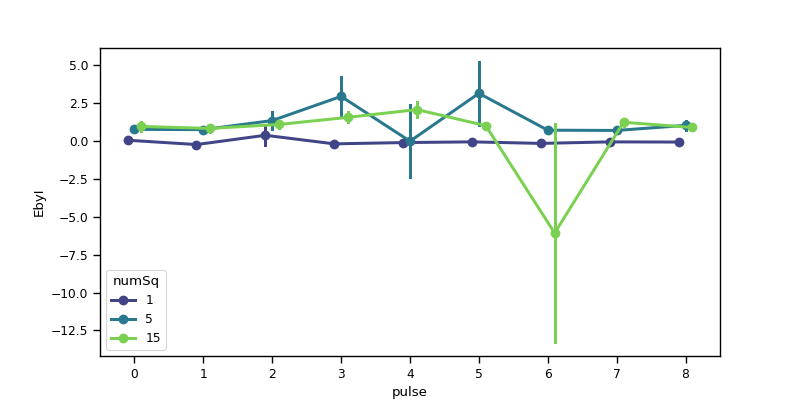

In [68]:
# box plot of delayEI across numSq and stimFreq
fig3bs10, ax3s10 = plt.subplots(1,1, figsize=(8,4))
sns.pointplot(data=ebyi_df, x='pulse', y='EbyI', hue='numSq', hue_order=[1,5,15], ax=ax3s10, palette=color_squares, errorbar='se', dodge=0.2)
# save fig
fig3bs10.savefig(paper_figure_export_location / 'Figure3s10_EbyI_vs_pulse_vsnumsq.png', dpi=300, bbox_inches='tight')
fig3bs10.savefig(paper_figure_export_location / 'Figure3s10_EbyI_vs_pulse_vsnumsq.svg', dpi=300, bbox_inches='tight')

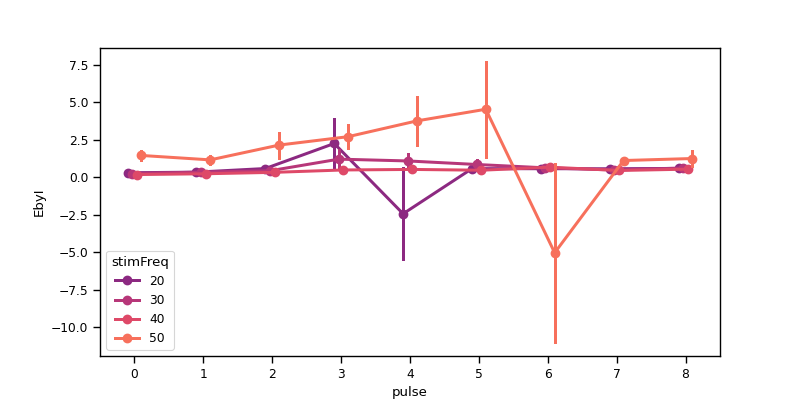

In [69]:
# box plot of delayEI across numSq and stimFreq
fig3s11, ax3s11 = plt.subplots(1,1, figsize=(8,4))
sns.pointplot(data=ebyi_df, x='pulse', y='EbyI', hue='stimFreq', ax=ax3s11, palette=color_freq, errorbar='se', dodge=0.2)
# save fig
fig3s11.savefig(paper_figure_export_location / 'Figure3s11_EbyI_vspulse_vsstimFreq.png', dpi=300, bbox_inches='tight')
fig3s11.savefig(paper_figure_export_location / 'Figure3s11_EbyI_vspulse_vsstimFreq.svg', dpi=300, bbox_inches='tight')

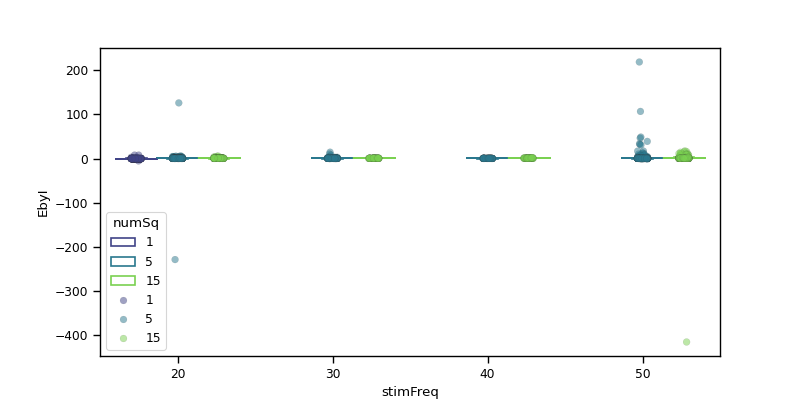

In [70]:
# box plot of EbyI across numSq and stimFreq
fig3s12, ax3bs12 = plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data=ebyi_df, x='stimFreq', y='EbyI', hue='numSq', hue_order=[1,5,15], dodge=True, ax=ax3bs12, palette=color_squares, fliersize=0, fill=False)
sns.stripplot(data=ebyi_df, x='stimFreq', y='EbyI', hue='numSq', hue_order=[1,5,15], dodge=True, ax=ax3bs12, palette=color_squares, linewidth=0.1, alpha=0.5)
#save fig
fig3s12.savefig(paper_figure_export_location / 'Figure3s12_EbyI_vsfreq_vsnumsq.png', dpi=300, bbox_inches='tight')
fig3s12.savefig(paper_figure_export_location / 'Figure3s12_EbyI_vsfreq_vsnumsq.svg', dpi=300, bbox_inches='tight')

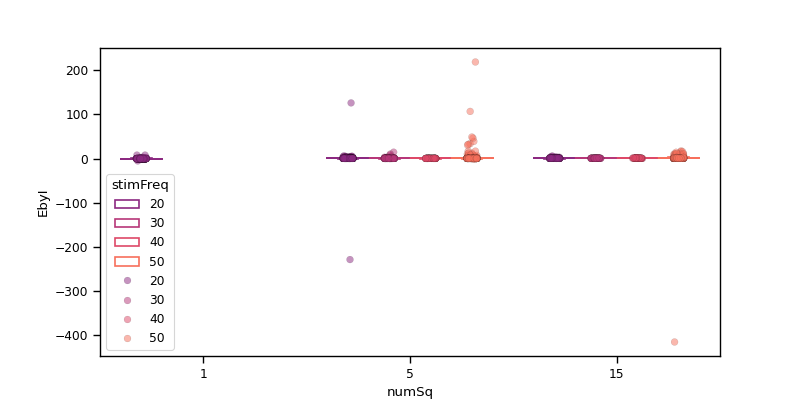

In [71]:
# box plot of delayEI across numSq and stimFreq
fig3s13, ax3s13 = plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data=ebyi_df, x='numSq', y='EbyI', hue='stimFreq', dodge=True, ax=ax3s13, palette=color_freq, fliersize=0, fill=False)
sns.stripplot(data=ebyi_df, x='numSq', y='EbyI', hue='stimFreq', dodge=True, ax=ax3s13, palette=color_freq, linewidth=0.1, alpha=0.5)
# save fig
fig3s13.savefig(paper_figure_export_location / 'Figure3s13_EbyI_vsnumsq_vsstimFreq.png', dpi=300, bbox_inches='tight')
fig3s13.savefig(paper_figure_export_location / 'Figure3s13_EbyI_vsnumsq_vsstimFreq.svg', dpi=300, bbox_inches='tight')